<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab    


*Authors:*  
 - Joseph Nelson (DC)        
 - Boom Devahastin Na Ayudhya (NYC)     
 - Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [2]:
data.shape

(421570, 4)

In [3]:
data.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [5]:
# there is not missing data
# format the date to datatime
data.index = pd.to_datetime(data.index)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [6]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [7]:
store = data[data['Store'] == 1]

In [8]:
Weekly_Sales = pd.DataFrame(store['Weekly_Sales'].resample('W').sum())

In [9]:
Weekly_Sales

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68
...,...
2012-09-30,1437059.26
2012-10-07,1670785.97
2012-10-14,1573072.81


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

Text(0.5, 1.0, 'Weekly Sales by Store')

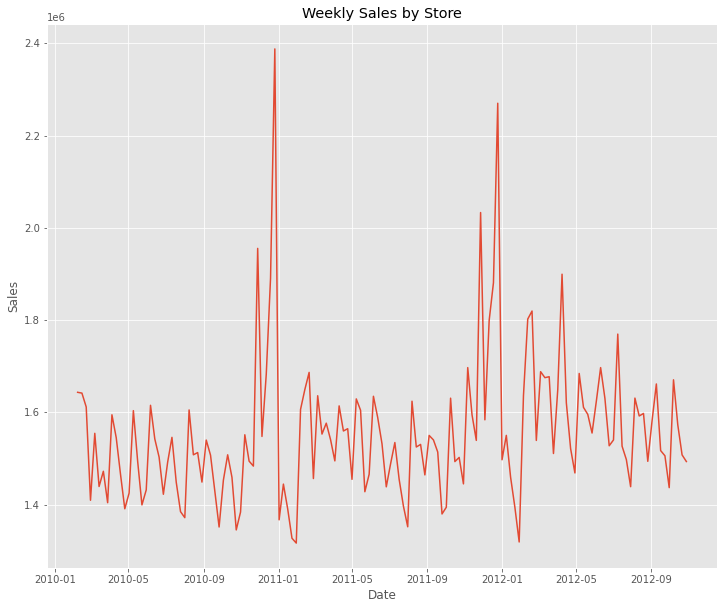

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.plot(Weekly_Sales)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Weekly Sales by Store')

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

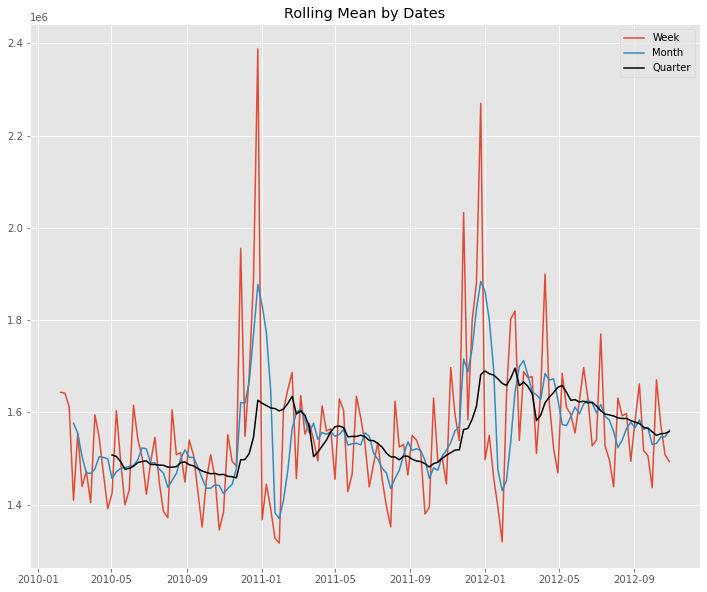

In [11]:
# rolling r1-week, r4-month, r13-Quarterly
r1 = Weekly_Sales.rolling(window = 1).mean()
r4 = Weekly_Sales.rolling(window = 4).mean()
r13 = Weekly_Sales.rolling(window = 13).mean()

# Plot
plt.figure(figsize=(12,10))
plt.plot(r1, label='Week')
plt.plot(r4, label='Month')
plt.plot(r13, label='Quarter', color='black')

plt.legend(loc='best')

plt.title('Rolling Mean by Dates')
plt.show()

**2c. What can you say about patterns in the data based on the rolling mean plot above?**

*Answer:*
1. There are repeated pattern that holiday spikes each year, since wine sales increase in holiday seasons.
2. Rolling by weeks shows high variation in sales, while rolling by quarters shows the least varation. 

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [12]:
lag1 = Weekly_Sales['Weekly_Sales'].autocorr(lag=1)
lag2 = Weekly_Sales['Weekly_Sales'].autocorr(lag=2)
lag10 = Weekly_Sales['Weekly_Sales'].autocorr(lag=10)
lag30 = Weekly_Sales['Weekly_Sales'].autocorr(lag=30)
lag100 = Weekly_Sales['Weekly_Sales'].autocorr(lag=100)
lag52= Weekly_Sales['Weekly_Sales'].autocorr(lag=52)

In [13]:
print(lag1)
print(lag2)
print(lag10)
print(lag30)
print(lag100)
print(lag52)

0.3021582794113126
0.12741313055390097
0.026628460093110463
-0.1015546455385977
0.1829039323132951
0.8953760294777008


**3b. What can you say about the series based on these autocorrelations?**

Answer:
1. there is defintely correlations between week lags and sales( postive or negative)
2. from lag1 to lag2, and lag 10, there seems a decrease in correlation, which shows more week lags, the less influence on Sales. 
3. However, lag52 shows a strong correlation and influence on sales. Which indicates there is seasonal associatiion with Sales. 

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

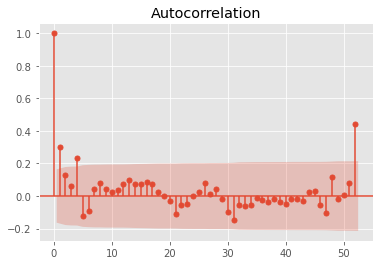

In [14]:
# 52-week acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(Weekly_Sales, lags=52);

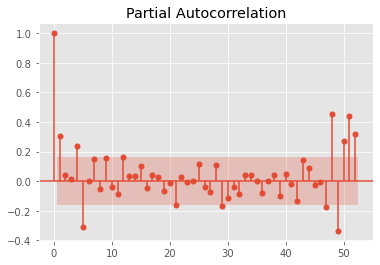

In [15]:
# 52-week pacf
plot_pacf(Weekly_Sales, lags=52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:
1. x-axis is the date and y-axis is the lags correlation with sales. 
2. the lags week correlation is decreasing with time
3. the color band is the 95% confidence intervals.
4. from week lags 1, the correlation is diminishing(except 4) non-significantly till 52.
5. on PACF, there are few week lags significantly correlated with sales, but not showed up in ACA figures, such as lag 5. 

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:
There is strong correlation on week 1 and 2.
There is also strong correlation on week 5, etc
We will inlcude these weeks in our model.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data. You can do this using `train_test_split` with a specific parameter, or can manually define it how it is set up below.

In [16]:
Weekly_Sales

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68
...,...
2012-09-30,1437059.26
2012-10-07,1670785.97
2012-10-14,1573072.81


In [17]:
len(Weekly_Sales)*0.75

107.25

In [18]:
train = Weekly_Sales.iloc[:108,]
test = Weekly_Sales.iloc[108:,]

In [19]:
train.shape

(108, 1)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [20]:
AR1 = AR(endog=train)

In [21]:
AR1.fit()

In [22]:
preds = AR1.fit().predict(start=test.index[0],
                         end = test.index[-1])

In [23]:
preds = pd.DataFrame(preds, columns =['Weekly_Sales'])

In [24]:
preds

,Weekly_Sales
2012-03-04,1.640488e+06
2012-03-11,1.534725e+06
2012-03-18,1.604942e+06
2012-03-25,1.468771e+06
2012-04-01,1.579684e+06
2012-04-08,1.542231e+06
2012-04-15,1.578813e+06
2012-04-22,1.525975e+06
2012-04-29,1.551847e+06
2012-05-06,1.556353e+06


**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [25]:
# calculate mse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, preds)
mse

9834237361.270823

**6c. How effective do you think this `AR(1)` model is?**

Answer:
Since the figure has seasonal pattern. Using only ARIMA may not be good model to catch the season impact. 

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [26]:
# calculate residuals
residuals = test - preds

Text(0.5, 1.0, 'Residual plot')

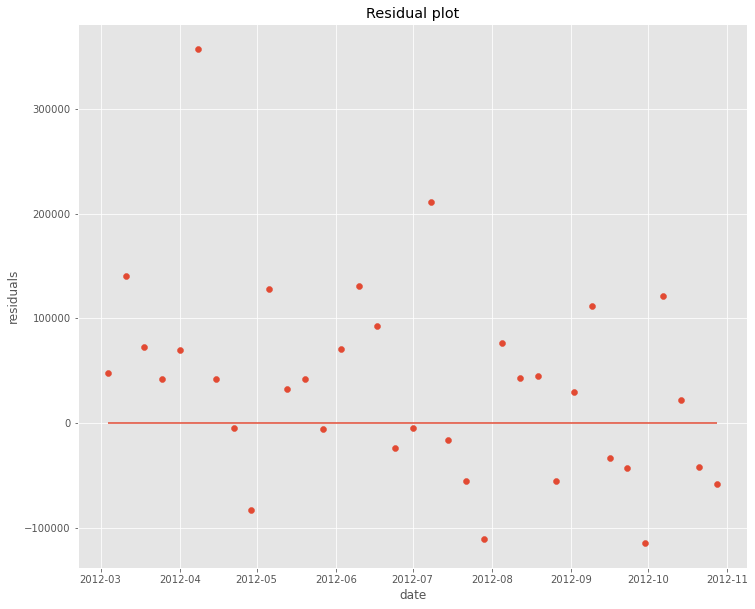

In [27]:
plt.figure(figsize=(12, 10))
plt.scatter(test.index, residuals)
plt.hlines(y=0,
          xmin=test.index.min(),
          xmax=test.index.max())
plt.xlabel('date')
plt.ylabel('residuals')
plt.title('Residual plot')

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:
The residual plot is converging with time, indicating the prediction is closer to the actual values.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [28]:
AR2 = ARIMA(endog=train, order=(2,0,0))   # 1,0,0 is same as AR, so we change to 2,0,0

In [29]:
AR2.fit()

In [30]:
preds2 = AR2.fit().predict(start=test.index[0],
                         end = test.index[-1])

In [31]:
preds2 = pd.DataFrame(preds2, columns =['Weekly_Sales'])

In [32]:
mse2 = mean_squared_error(test, preds2)
mse2

11333861974.339212

In [33]:
mse-mse2

-1499624613.06839

In [34]:
# calculate residuals
residuals2 = test - preds2

Text(0.5, 1.0, 'Residual plot2')

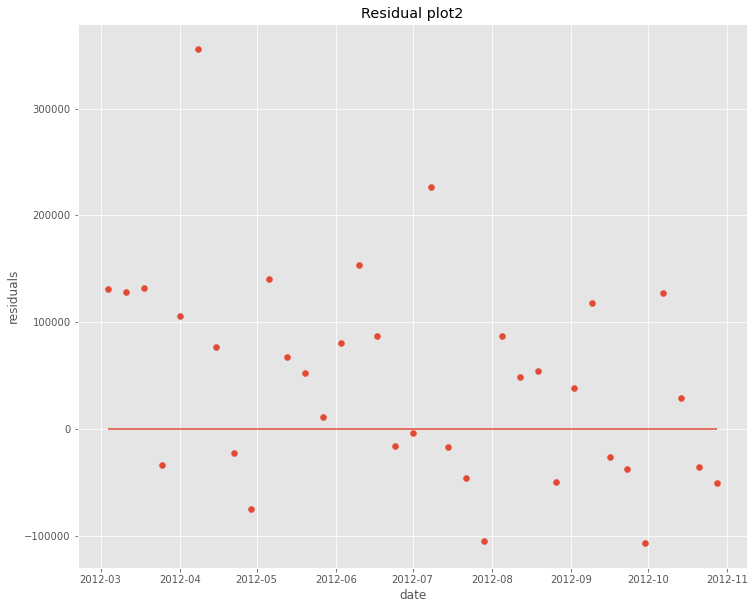

In [35]:
plt.figure(figsize=(12, 10))
plt.scatter(test.index, residuals2)
plt.hlines(y=0,
          xmin=test.index.min(),
          xmax=test.index.max())
plt.xlabel('date')
plt.ylabel('residuals')
plt.title('Residual plot2')

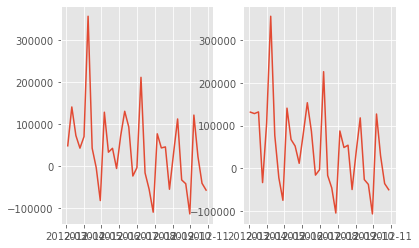

In [36]:
fig, ax = plt.subplots(1,2)
ax[0].plot(residuals)
ax[1].plot(residuals2)

**8b. How did your results change?**

Answer:
From the figures, hard to tell the difference. But the mse of AR1 is big than AR2.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [37]:
AR22 = ARIMA(endog=train,order=(2,0,2))

In [38]:
AR22.fit()

In [39]:
preds3 = AR22.fit().predict(start=test.index[0],
                         end = test.index[-1])

In [40]:
preds3 = pd.DataFrame(preds3, columns =['Weekly_Sales'])

In [41]:
mse3 = mean_squared_error(test, preds3)
mse3

11347846625.385557

In [42]:
mse-mse3

-1513609264.1147346

In [43]:
# calculate residuals
residuals3 = test - preds3

Text(0.5, 1.0, 'Residual plot3')

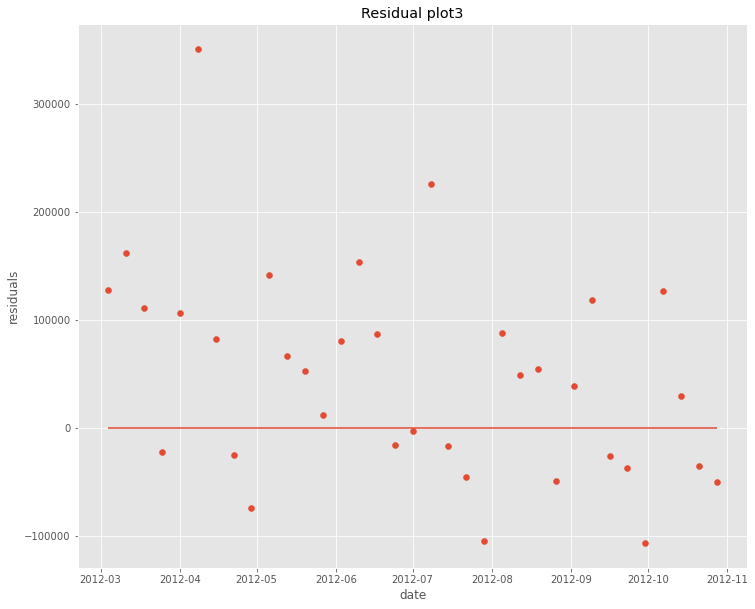

In [44]:
plt.figure(figsize=(12, 10))
plt.scatter(test.index, residuals3)
plt.hlines(y=0,
          xmin=test.index.min(),
          xmax=test.index.max())
plt.xlabel('date')
plt.ylabel('residuals')
plt.title('Residual plot3')

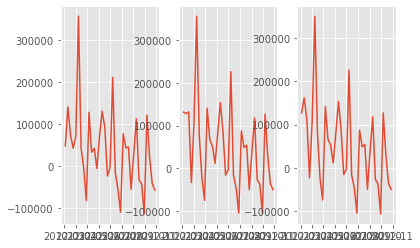

In [45]:
fig, ax = plt.subplots(1,3)
ax[0].plot(residuals)
ax[1].plot(residuals2)
ax[2].plot(residuals3)

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



In [46]:
mse2-mse3

-13984651.046344757

Answer:
Same as above, hard to tell the difference from the figures. but the AR22 MSE is even bigger than AR2. 


#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [47]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller
# Run ADF test on original (non-differenced!) data.
adfuller(train)

(-4.741809005136401,
 7.01819532748343e-05,
 4,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 2526.596847657764)

In [48]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [49]:
interpret_dftest(adfuller(train))

Test Statistic   -4.741809
p-value           0.000070
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:
The null hypothesis of ADF test is that there is a unit root in an AR model, which implies that the data series is not stationary. However, based on the p-value: 0.00007, which is less than a. The alternative hypothesis reject the null hypothesis. The data is stationary.

#### 10. Differenced Data

Regardless of what you found above, now we're going to take a look at differenced data.

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [50]:
Weekly_Sales['1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['3'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales.head()

,Weekly_Sales,1,2,3
Date,,,,
2010-02-07,1643690.90,NaN,NaN,NaN
2010-02-14,1641957.44,-1733.46,NaN,NaN
2010-02-21,1611968.17,-29989.27,-31722.73,NaN
2010-02-28,1409727.59,-202240.58,-232229.85,-233963.31
2010-03-07,1554806.68,145079.09,-57161.49,-87150.76


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [51]:
Weekly_Sales.dropna(inplace= True)

In [52]:
for col in Weekly_Sales.columns:
    print(f' {col} : {interpret_dftest(adfuller(Weekly_Sales[col]))}')

 Weekly_Sales : Test Statistic   -5.066985
p-value           0.000016
dtype: float64
 1 : Test Statistic   -7.215337e+00
p-value           2.180627e-10
dtype: float64
 2 : Test Statistic   -6.227124e+00
p-value           5.056800e-08
dtype: float64
 3 : Test Statistic   -5.160622
p-value           0.000011
dtype: float64


**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:
Since all the p-values are small. There is no need to differece the data.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:
It's Stationary data. It makes sense to use ARIMA model. 
It's not only autoregression, but also the moving average should be intergreted.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Using whichever metric(s) you think best suit this problem (don't forget to import them above!), evaluate your model on the training and testing sets and generate a residual plot.**

In [53]:
ARIMA_d = ARIMA(endog=train, order=(2, 0, 2))

In [54]:
ARIMA_d.fit()

In [55]:
pred_d = ARIMA_d.fit().predict(start=test.index[0],
                         end = test.index[-1])

In [56]:
mse_d = mean_squared_error(test, pred_d)
mse_d

11347846625.385557

**11b. Interpret the results from the last answer.**


Answer:
There is no need to do difference, so I choose d=0, which is same as ARIMA(2,0,2) we did before. the mse based on d is same as mse3.

#### 12.  BONUS [12a-12b]: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [58]:
stepwise_sarima = auto_arima(
    train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 52, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1416.238, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1393.593, Time=1.27 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1393.428, Time=1.47 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1401.671, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=5.62 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1392.814, Time=6.45 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1394.807, Time=8.36 sec
 ARIMA(0,1,1)(0,1,3)[52]             : AIC=inf, Time=34.58 sec
 ARIMA(0,1,1)(1,1,3)[52]             : AIC=inf, Time=27.55 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=1395.993, Time=4.67 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=1394.833, Time=9.32 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=inf, Time=22.43 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=1392.819, Time=4.84 sec
 ARIMA(1,1,2)(0,1,2)[52]             : AIC=1400.386, Time=7.61 sec
 ARIMA(0,1,1)(0,1,2)[52] intercept  

In [59]:
# best order
stepwise_sarima.order

(0, 1, 1)

In [60]:
# best seasonal order?
stepwise_sarima.seasonal_order

(0, 1, 2, 52)

In [61]:
# Check summary to ensure no problems
stepwise_sarima.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 52)   Log Likelihood                -692.407
Date:                                 Tue, 31 Aug 2021   AIC                           1392.814
Time:                                         11:58:24   BIC                           1400.844
Sample:                                              0   HQIC                          1395.919
                                                 - 108                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1376      0.036     -3.866      0.000      -0.207      -0.068
ma.S.L52      -0.1847      0.056     -3.296      0.001      -0.294      -0.075
ma.S.L104     -0.0898      0.073     -1.233      0.218      -0.233       0.053
sigma2      4.355e+09   1.11e-12   3.93e+21      0.000    4.36e+09    4.36e+09
===================================================================================
Ljung-Box (L1) (Q):                  12.48   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.00   Prob(JB):                         0.87
Heteroskedasticity (H):               0.83   Skew:                             0.05
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.92e+37. Standard errors may be unstable.
"""

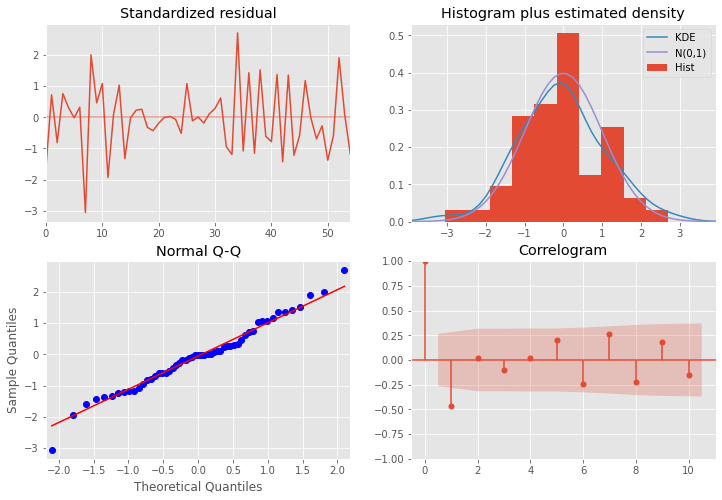

In [62]:
# nice quick graphs of results
stepwise_sarima.plot_diagnostics(figsize = (12, 8));

In [63]:
# p,d,q (0, 1, 1)
# P,D,Q,S (0, 1, 2, 52)
def sarima_grid_search(data, p_range = (0,1), q_range = (0,1), P_range = (0,1), Q_range = (0,2), d = 0, D_range = (0,1) , S = 52, verbose = False):
    best_aic = 99 * (10 ** 16) # a very large number
    best_order = None
    best_seasonal_order = None
    best_model = None
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range[0], p_range[1] + 1): # adding 1 so range is inclusive
        for q in range(q_range[0], q_range[1] + 1): # adding 1 so range is inclusive
            for P in range(P_range[0], P_range[1] + 1): # adding 1 so range is inclusive
                for Q in range(Q_range[0], Q_range[1] + 1): # adding 1 so range is inclusiv
                    for D in range(D_range[0], D_range[1]+1):
                    # Insert try and except statements.
                        try:
                            # Fitting an SARIMA(p, d, q) & (P, D, Q, S) model.
                            if verbose:
                                print(f'Attempting to fit SARIMA({p},{d},{q}) & ({P},{D},{Q},{S})')
                            order = (p,d,q) # values of p, d, q
                            seasonal_order = (P, D, Q, S)
                            # Instantiate SARIMA model.
                            sarima = SARIMAX(data, # endog = Y variable
                                          order = order,
                                          seasonal_order = seasonal_order) 

                            # Fit SARIMA model.
    #                         model = sarima.fit()
                            # If getting Convergence Errors, try increasing maxiter and changing method
                            model = sarima.fit(maxiter = 200, method = "powell", disp = 0) # disp = 0 b/c of excessive output


                            if verbose:
                                print(f'The AIC for SARIMA({p},{d},{q})  & ({P},{D},{Q},{S}) is: {model.aic}')

                            # Is my current model's AIC better than our best_aic?
                            if model.aic < best_aic:

                                # If so, let's overwrite best found so far
                                best_aic = model.aic
                                best_order = order
                                best_seasonal_order = seasonal_order
                                best_model = model

                        except Exception as e:
                            print(e)
                            pass

        return {
            "best_aic": best_aic, 
            "best_order" : best_order, 
            "best_seasonal_order" : best_seasonal_order, 
            "best_model": best_model
        }

In [64]:
sarima_grid_search(train, d = 0, S = 52, verbose = True)

Attempting to fit SARIMA(0,0,0) & (0,0,0,52)
The AIC for SARIMA(0,0,0)  & (0,0,0,52) is: 3387.7095903061627
Attempting to fit SARIMA(0,0,0) & (0,1,0,52)
The AIC for SARIMA(0,0,0)  & (0,1,0,52) is: 1423.3801886783308
Attempting to fit SARIMA(0,0,0) & (0,0,1,52)
The AIC for SARIMA(0,0,0)  & (0,0,1,52) is: 3329.6841908188044
Attempting to fit SARIMA(0,0,0) & (0,1,1,52)
The AIC for SARIMA(0,0,0)  & (0,1,1,52) is: 1406.8154041447353
Attempting to fit SARIMA(0,0,0) & (0,0,2,52)
The AIC for SARIMA(0,0,0)  & (0,0,2,52) is: 3303.171074768964
Attempting to fit SARIMA(0,0,0) & (0,1,2,52)
The AIC for SARIMA(0,0,0)  & (0,1,2,52) is: 1398.8773142116675
Attempting to fit SARIMA(0,0,0) & (1,0,0,52)
The AIC for SARIMA(0,0,0)  & (1,0,0,52) is: 3055.3713287654514
Attempting to fit SARIMA(0,0,0) & (1,1,0,52)
The AIC for SARIMA(0,0,0)  & (1,1,0,52) is: 1406.585036737693
Attempting to fit SARIMA(0,0,0) & (1,0,1,52)
The AIC for SARIMA(0,0,0)  & (1,0,1,52) is: 3057.4690986553946
Attempting to fit SARIMA(0,0,0

{'best_aic': 1398.8773142116675,
 'best_order': (0, 0, 0),
 'best_seasonal_order': (0, 1, 2, 52),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fd474403460>}

In [65]:
sarima = SARIMAX(endog = train,
                order = (0,0,0),
                seasonal_order=(0,1,2,52)).fit()
sarima_pred = sarima.predict(start=test.index[0],
                         end = test.index[-1])
mse_sarima = mean_squared_error(test, sarima_pred)

**12b. How did your best SARIMAX model perform?**

Answer:
compared with mse, mse2, mse3, mse_d, the mse_sarima is the smallest! 

### 13. Your Best Model

**13a. How did you decide this was your best model? How does your model perform at predicting weekly sales moving forward? Please use the metrics/visuals you included above to support your answer.** 

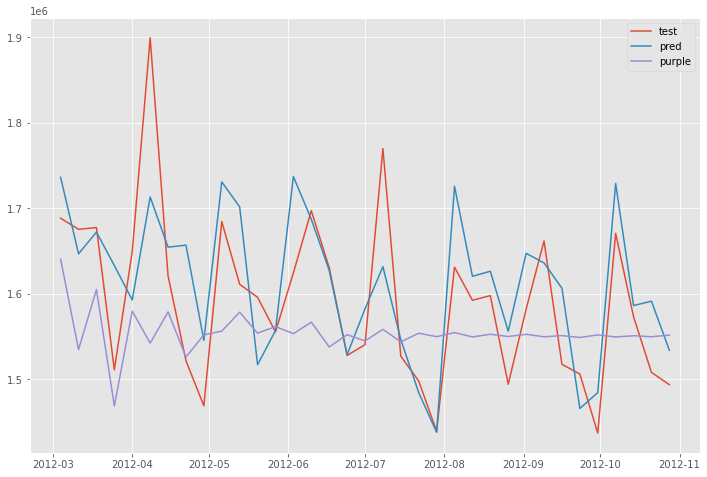

In [68]:
sarima_pred = pd.DataFrame(sarima_pred)
plt.figure(figsize=(12, 8))
plt.plot(test, label='test')
plt.plot(sarima_pred,label='pred');
plt.plot(preds,label='purple')
plt.legend();

**13b. How might you improve this model?**

1. change seasonal parameter S from 52 to 365, or 12 
2. Get more data
3. based on the curve above, very begining the prediction variation is bigger and eventually lower down, which seems a sign to adjust the parametes in rolling or Moving average values.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: